In [1]:
import numpy as np
import sympy as sp
import pints
import pints.toy
import matplotlib.pyplot as plt

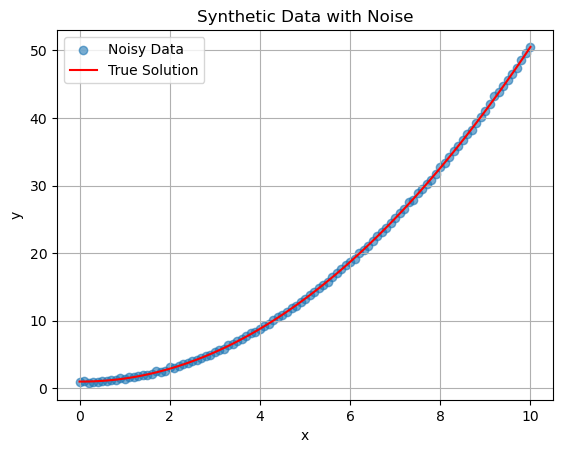

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      55471.36  55471.36   0:00.0
1     12     51504.45  51504.45   0:00.0
2     18     50626.44  50626.44   0:00.0
3     24     38294.87  38294.87   0:00.0
20    126    71.86368  71.86368   0:00.0
40    246    0.969     0.969      0:00.1
60    366    0.969361  0.969361   0:00.1
80    486    0.969361  0.969361   0:00.2
100   606    0.969361  0.969361   0:00.2
120   726    0.969361  0.969361   0:00.3
140   846    0.969361  0.969361   0:00.3
160   966    0.969361  0.969361   0:00.3
180   1086   0.969361  0.969361   0:00.4
200   1206   0.969361  0.969361   0:00.4
220   1326   0.969361  0.969361   0:00.5
240   1446   0.969361  0.969361   0:00.5
260   1566   0.969361  0.969361   0:00.5
279   1674   0.969361  0.969361   0:00.6
Halting: No significant change for 200 iterations.
Estimated parameters: {'k': np.floa

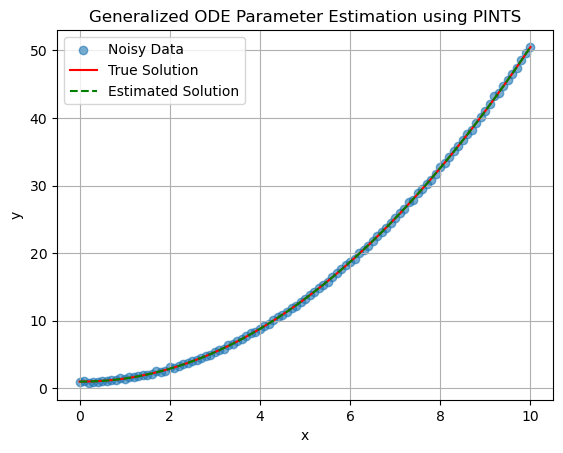

In [6]:
class GeneralODEModel(pints.ForwardModel):
    def __init__(self, equation_str, parameters, x_values, step_size):
        """
        Generalized ODE model for parameter estimation.
        
        Parameters:
        - equation_str: The ODE as a string (e.g., "-k*x + b").
        - parameters: List of parameters to estimate (e.g., ['k', 'b']).
        - x_values: The x-values (time or independent variable).
        - step_size: The step size for numerical integration.
        """
        self.x_values = x_values
        self.step_size = step_size
        self.parameters = parameters

        # Define symbols
        self.x, self.y = sp.symbols('x y')
        self.param_symbols = [sp.Symbol(p) for p in parameters]

        # Convert equation string to a SymPy function
        self.ode_function = sp.sympify(equation_str)

        # Compile function for speed
        self.ode_lambda = sp.lambdify([self.x, self.y] + self.param_symbols, self.ode_function, 'numpy')

    def simulate(self, parameters, times):
        """Simulate the ODE using Euler’s method for given parameters."""
        y_values = [1.0]  # Assume y0 = 1 (can be generalized)
        for i in range(len(self.x_values) - 1):
            y_prev = y_values[-1]
            x_curr = self.x_values[i]
            dydx = self.ode_lambda(x_curr, y_prev, *parameters)
            y_next = y_prev + self.step_size * dydx
            y_values.append(y_next)
        return np.array(y_values)

    def n_parameters(self):
        """Return the number of parameters to estimate."""
        return len(self.param_symbols)

    def generate_synthetic_data(self, true_params, noise_std=0.1):
        """Generate synthetic noisy data from the true ODE solution."""
        y_values = self.simulate(true_params, self.x_values)
        y_noisy = y_values + np.random.normal(0, noise_std, size=y_values.shape)
        return y_values, y_noisy

    def optimize_parameters(self, y_noisy, method=pints.CMAES):
        """Optimize parameters using PINTS."""
        problem = pints.SingleOutputProblem(self, self.x_values, y_noisy)
        error_measure = pints.SumOfSquaresError(problem)
        optimizer = pints.OptimisationController(error_measure, [0.1] * len(self.parameters), method=method)
        optimizer.set_max_iterations(1000)
        estimated_params, _ = optimizer.run()
        return estimated_params

if __name__ == "__main__":
    equation_str = "-k*x + b"
    parameters = ['k', 'b']
    true_params = [-1, 0]
    x0, y0, x_end, step_size = 0, 1, 10, 0.1
    x_values = np.arange(x0, x_end + step_size, step_size)

    model = GeneralODEModel(equation_str, parameters, x_values, step_size)
    y_true, y_noisy = model.generate_synthetic_data(true_params)

    plt.scatter(x_values, y_noisy, label="Noisy Data", alpha=0.6)
    plt.plot(x_values, y_true, 'r-', label="True Solution")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Synthetic Data with Noise")
    plt.grid()
    plt.show()

    estimated_params = model.optimize_parameters(y_noisy)
    print(f"Estimated parameters: {dict(zip(parameters, estimated_params))}")

    y_estimated = model.simulate(estimated_params, x_values)
    plt.scatter(x_values, y_noisy, label="Noisy Data", alpha=0.6)
    plt.plot(x_values, y_true, 'r-', label="True Solution")
    plt.plot(x_values, y_estimated, 'g--', label=f"Estimated Solution")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Generalized ODE Parameter Estimation using PINTS")
    plt.grid()
    plt.show()